Proposta desta análise é obter um modelo que de recomendação de compra para os clientes com maior potencial de recompra.

Utilizaremos a biblioteca lifetimes que ajudará a estimar a expectativa de vida de clientes e com isto o modelo irá predizer a expectativa de recompra de dado cliente.


Esta análise e modelo teve como fonte o trabalho apresentado em https://www.kaggle.com/code/mhuang22/predicting-customer-lifetime-value-for-e-commerce

Foi feito um estudo detalhado do mesmo, e ele será incorporado em nossa infra-estrutura. 

Links úteis:
https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html
https://readthedocs.org/projects/lifetimes/downloads/pdf/latest/
https://snyk.io/advisor/python/Lifetimes/example 
https://medium.com/@ugursavci/customer-lifetime-value-prediction-in-python-89e4a50df12e

https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gam
ma-gamma-model
“Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model by Fader et al. in 2005. http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

In [45]:
# Importes necessários para explorar este tipo de dados
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

#Entrada e análise dos dados "Brutos" - Bronze

Neste ponto os nossos dados já estão anonimazados (camada bronze), contudo a é esperado que isso ocorra na etapa anterior.

Raw -> Bronze

In [48]:
customers_raw = pd.read_csv("/content/drive/MyDrive/tcc_iti/data_olist/olist_customers_dataset.csv")
orders_raw = pd.read_csv("/content/drive/MyDrive/tcc_iti/data_olist/olist_orders_dataset.csv", parse_dates = ['order_purchase_timestamp'])
orderItems_raw = pd.read_csv("/content/drive/MyDrive/tcc_iti/data_olist/olist_order_items_dataset.csv")

In [49]:
# Verificação simples de como estão dispostos os dados de clientes na base de entrada
customers_raw.info()

customers_raw.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [50]:
customers = customers_raw[['customer_id', 'customer_unique_id']]
customers.head()

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066


In [51]:
# Verificação simples de como estão dispostos os dados de pedidos na base de entrada
orders_raw.info()
orders_raw.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-10-17 17:30:18,NaN,NaN,NaN,NaN


In [52]:
# Analisando quais os tipos de pedidos. 
orders_raw['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [53]:
# Não faz sentido pedidos cancelados. Se foi cancelado será desconsiderado 
orders_raw = orders_raw[orders_raw.order_status != 'canceled']
orders_raw['date'] = pd.to_datetime(orders_raw['order_purchase_timestamp']).dt.date

In [54]:
# Analise dos pedidos por cliente e data
orders = orders_raw[['order_id', 'customer_id','date']]
orders.head()

,order_id,customer_id,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13


In [11]:
# Verificação simples de como estão dispostos os dados de itens por pedido na base de entrada
orderItems_raw.info()
orderItems_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [55]:
# quantidade de pedidos não itens
orderItems_raw['order_id'].nunique()

98666

Com o dataset, orderItems, iremos gerar a informação de valor total de cada pedido. Faremos uma agregação de order_id e uma soma dos preços totais.

In [56]:
orderTrans = orderItems_raw.groupby(['order_id']).agg({'price':'sum'}).reset_index()
orderTrans.rename(columns={'price':'revenue'}, inplace = True)
orderTrans

,order_id,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


Iremos agora reunir o dataset de pedido (orders) com o de receita e data de cada pedido. Com isso teremos o dataset orderDetails. Este conterá a relação pedidoXCliente e valor total de compra. 

In [57]:
orderDetails = pd.merge(orders, orderTrans, on = 'order_id', how = 'left')
orderDetails

,order_id,customer_id,date,revenue
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13,19.90
...,...,...,...,...
98811,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09,72.00
98812,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06,174.90
98813,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27,205.99
98814,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08,359.98


Agora agregaremos o dataset de cliente, atraves deste o customer_unique_id com o dataset trabalhado até o momento (pedidoXCliente e valor total de compra)

In [58]:
orderCusDetails_raw = pd.merge(customers, orderDetails, on = 'customer_id', how = 'left')
orderCusDetails_raw

,customer_id,customer_unique_id,order_id,date,revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,230.00
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07,74.90
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04,114.90
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08,37.00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03,689.00


O campo customer_unique_id é um campo unico por cada cliente. Diferente do campo customer_id que é unico por pedido. Ou seja, para um mesmo customer_unique_id haverá diferentes customer_id.

Aqui foi feito uma validação de como esta o dados para um dado customer_unique_id.

In [59]:
orderCusDetails_raw[orderCusDetails_raw['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_id,customer_unique_id,order_id,date,revenue
28432,6152d0774bbbf74f7140541c0569dafa,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05,10.9
35693,588047d7101d88c333691e47659d7099,12f5d6e1cbf93dafd9dcc19095df0b3d,ca5a215980675471f0cf8199c041909a,2017-01-05,10.9
71569,c0352e94059e3e5a714c9ad0c8306a54,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,2017-01-05,9.9
89230,27129ce1ebca4ffa23a049c51cc8ec95,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,2017-01-05,6.9
97034,ed1793d2d1e4175d5846ce7ebb4a01f5,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,2017-01-05,9.9
98493,a969b9f8d923bc7fd97b578f7c499194,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,2017-01-05,9.9


Na próxima etapa será feito a agregação dos pedidos de compra para cada cliente por data. Com isto teremos a Relação Cliente X Data X valor gasto em compras.

In [60]:
orderCusDetails = orderCusDetails_raw.groupby(['customer_unique_id','date']).agg({'revenue':'sum'}).reset_index()
orderCusDetails

,customer_unique_id,date,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00
...,...,...,...
97872,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,1570.00
97873,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89
97874,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90
97875,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00


In [61]:
orderCusDetails[orderCusDetails['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_unique_id,date,revenue
7299,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05,58.4


Aqui foi pego o total a unicidade de clientes nesta base, validando que não há duplicidade de informação.

In [62]:
orderCusDetails['customer_unique_id'].nunique()

95560

In [63]:
#copia para uso posterior e garantir que não afetará o trabalho até aqui
df = orderCusDetails.copy()

In [64]:
print('Min : {}, Max : {}'.format(min(df['date']), max(df['date'])))
lastDate = max(df['date']) + dt.timedelta(1)
print(lastDate)

Min : 2016-09-04, Max : 2018-09-03
2018-09-04


# Aqui teremos um trabalho de tratar e selecionar as features (Silver)
Visando obter a ressencia, ou seja, o intervalo e posterior frequencia de compra de cada cliente faremos uma sequencia de passos, sempre utilizando a etapa anterior para avançar a próxima.

df1:- para cada cliente, usará a data mas recente no intervalo analiso, obterá a diferença com a data de compra, será em dias corridos na coluna 'T'.

df2:- para cada cliente, buscará a diferença, em dias corridos, entre cada compra feita por este usuario. Casos cuja coluna recency seja igual a 0 indicam compra única no período. Será feito a limpa deste valores neste dataFrame.

df3:- para cada cliente, agregaremos por data e valor gastos. Assim teremos a frequência e valor de compra de cada cliente. Ainda neste dataFrame (df3) obteremos a média gasta por compra, e será feito um tratamendo de modo a que quem possuir frequencia igual a 0, será aqueles que fizeram duas compras no período.



In [65]:
df1 = df.groupby('customer_unique_id') .agg({'date': lambda x:(lastDate - x.min()).days}).reset_index()
df1.rename(columns = {'date':'T'}, inplace = True)
df1

,customer_unique_id,T
0,0000366f3b9a7992bf8c76cfdf3221e2,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120
2,0000f46a3911fa3c0805444483337064,543
3,0000f6ccb0745a6a4b88665a16c9f078,327
4,0004aac84e0df4da2b147fca70cf8255,294
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453
95556,fffea47cd6d3cc0a88bd621562a9d061,268
95557,ffff371b4d645b6ecea244b27531430a,574
95558,ffff5962728ec6157033ef9805bacc48,125


In [ ]:
# df_temp = df1.sort_values(by='T')

# # type(df1)
# df_temp

In [66]:
df2 = df.groupby('customer_unique_id').agg({'date': lambda x:(x.max() - x.min()).days}).reset_index()
df2.rename(columns = {'date':'recency'}, inplace = True)
df2

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,0
4,0004aac84e0df4da2b147fca70cf8255,0
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0
95556,fffea47cd6d3cc0a88bd621562a9d061,0
95557,ffff371b4d645b6ecea244b27531430a,0
95558,ffff5962728ec6157033ef9805bacc48,0


In [67]:
# Testing
# df2[df2['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']
df2[df2['recency'] != 0]

,customer_unique_id,recency
106,004288347e5e88a27ded2bb23747066c,171
124,004b45ec5c64187465168251cd1c9c2f,267
248,00a39521eb40f7012db50455bf083460,11
412,011575986092c30523ecb71ff10cb473,60
427,011b4adcd54683b480c4d841250a987f,177
...,...,...
95107,fed519569d16e690df6f89cb99d4e682,88
95175,ff03923ad1eb9e32304deb7f9b2a45c9,33
95223,ff22e30958c13ffe219db7d711e8f564,10
95382,ff8892f7c26aa0446da53d01b18df463,186


In [68]:
df3 = df.groupby(['customer_unique_id']).agg({'date': 'count',                                             
                                             'revenue':'sum'}).reset_index()
df3.rename(columns = {'date':'frequency','revenue':'total_monetary'}, inplace = True)
df3

,customer_unique_id,frequency,total_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,1,64.89
95557,ffff371b4d645b6ecea244b27531430a,1,89.90
95558,ffff5962728ec6157033ef9805bacc48,1,115.00


In [69]:
df3['avg_monetary'] = df3['total_monetary'] / df3['frequency']
df3['frequency'] = df3['frequency'] - 1
df3 = df3.drop(columns=['total_monetary'])
df3

,customer_unique_id,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,18.90
2,0000f46a3911fa3c0805444483337064,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,0,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,0,115.00


In [70]:
# Testing
df3[df3['frequency'] != 0]
# df3[df3['customer_unique_id'] == '02168ea18740a0fdaaa15f11bebba5db']

,customer_unique_id,frequency,avg_monetary
106,004288347e5e88a27ded2bb23747066c,1,158.945000
124,004b45ec5c64187465168251cd1c9c2f,1,43.450000
248,00a39521eb40f7012db50455bf083460,1,40.725000
412,011575986092c30523ecb71ff10cb473,1,91.450000
427,011b4adcd54683b480c4d841250a987f,1,91.715000
...,...,...,...
95107,fed519569d16e690df6f89cb99d4e682,1,124.950000
95175,ff03923ad1eb9e32304deb7f9b2a45c9,1,110.320000
95223,ff22e30958c13ffe219db7d711e8f564,1,145.000000
95382,ff8892f7c26aa0446da53d01b18df463,1,138.975000


Visando recuperar as informações obtidas ao longo da última análise, Intervalo de dias, recência e frequencia de compra, e gasto médio por cliente. Será feito o merge dos dataFrames, em df_combined2.

In [71]:
df_combined1 = pd.merge(df1, df2, on = 'customer_unique_id', how = 'outer')
df_combined2 = pd.merge(df_combined1, df3, on = 'customer_unique_id', how = 'outer')
df_combined2

,customer_unique_id,T,recency,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00
...,...,...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453,0,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,268,0,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,574,0,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,125,0,0,115.00


In [72]:
orderCusDetails[orderCusDetails['customer_unique_id'] == 'ff922bdd6bafcdf99cb90d7f39cea5b3']

,customer_unique_id,date,revenue
97715,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-02-22,24.90
97716,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-08-23,40.00
97717,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-09-14,29.89


Removendo os valores com recencia igual a 0, pois não serão uteis para o nosso treinamento. Com isto, temos um dataframe para a análise de tempo de vida dos clientes.

In [73]:
df_combined2[df_combined2['recency'] != 0]

,customer_unique_id,T,recency,frequency,avg_monetary
106,004288347e5e88a27ded2bb23747066c,404,171,1,158.945000
124,004b45ec5c64187465168251cd1c9c2f,368,267,1,43.450000
248,00a39521eb40f7012db50455bf083460,104,11,1,40.725000
412,011575986092c30523ecb71ff10cb473,199,60,1,91.450000
427,011b4adcd54683b480c4d841250a987f,378,177,1,91.715000
...,...,...,...,...,...
95107,fed519569d16e690df6f89cb99d4e682,258,88,1,124.950000
95175,ff03923ad1eb9e32304deb7f9b2a45c9,134,33,1,110.320000
95223,ff22e30958c13ffe219db7d711e8f564,11,10,1,145.000000
95382,ff8892f7c26aa0446da53d01b18df463,468,186,1,138.975000


In [74]:
import lifetimes

#Tratamento nas features (Gold)

O dataframe obtido, df_combined2, servirá de input para o tratar as features de nosso modelo. 

Neste caso será removido aqueles clientes cuja especitativa de vida não atendem ao esperado, ou seja, clientes que tendem a não adiquirir mais produtos ao longo do tempo.


In [75]:

from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef = 0.005)
bgf.fit(df_combined2['frequency'], df_combined2['recency'], df_combined2['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 95560 subjects, a: 0.16, alpha: 71.25, b: 0.03, r: 0.02>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.016225,0.000855,0.014550,0.017900
alpha,71.252096,6.616464,58.283826,84.220367
a,0.156260,0.024295,0.108642,0.203878
b,0.026491,0.004651,0.017375,0.035608


Visualizando a Matriz de Frequência/Recência

Esta matriz calcula o número esperado de transações que um cliente artificial deve fazer no próximo período de tempo, considerando sua recência e frequência.

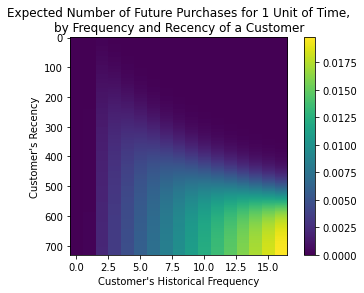

In [76]:
#Expected Number of Future Purchases for 1 Unit of Time
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

Podemos ver que, se um cliente comprou 15 vezes e sua última compra foi quando tinha 700 dias, ele é nosso melhor cliente (canto inferior direito). Logo, mais compras ao longo do tempo.

Área ao redor (4.350) - Clientes que compram com pouca frequência, mas nós os procuramos recentemente. Eles podem estar mortos ou apenas foram compras pontuais.

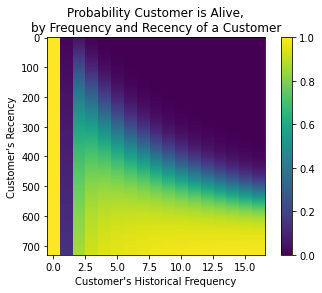

In [77]:
#Probability of Still Being Alive
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

Obtendo clientes que provavelmente comprarão novamente.

In [39]:
t = 1 # indica o proximo periodo
df_combined2['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_combined2['frequency'], df_combined2['recency'], df_combined2['T'])
df_combined2.sort_values(by='predicted_purchases', ascending=False).head()

,customer_unique_id,T,recency,frequency,avg_monetary,predicted_purchases
52676,8d50f5eadf50201ccdcedfb9e2ac8455,477,462,16,42.918824,0.028743
75650,ca77025e7201e3b30c44b472ff346268,330,235,6,115.230000,0.012946
83899,e0836a97eaae86ac4adc26fbb334a527,70,62,2,20.993333,0.012178
21458,394ac4de8f3acb14253c177f0e15bc58,256,236,4,126.632000,0.011504
70344,bc3e7032668d3f411c227eec09221362,81,59,2,42.633333,0.010950


A proposta é que os próximos passos virem uma API.  Ou seja, informando o usuario retornar o potencial de compra do mesmo. Isso será util para apresentação do TCC.

In [40]:
# t é o intervalo de tempo que ser prever futuras compras
t = 100 

In [41]:
#bucando por usuario qual sua info, o primeiro valor, ajudará a ter uma busca otimizada
print(df_combined2[df_combined2['customer_unique_id'] == 'db20b3f6a6a6e5ebb504771a6685085d'])

                     customer_unique_id    T  recency  frequency  \
81911  db20b3f6a6a6e5ebb504771a6685085d  505        0          0   

       avg_monetary  predicted_purchases  
81911         449.0             0.000028  


In [43]:
#conteudo de individual será input no modelo de predição de futura compra
individual = df_combined2.iloc[83899]


In [44]:
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.1478948515020717